In [1]:
import sys, os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential
from tslearn.preprocessing import TimeSeriesScalerMinMax
sys.path.append(os.path.join(os.path.dirname('Demand'), '..', 'src'))
from Demand import Demand

In [2]:
path = '../data/demand_lower_48'

In [3]:
national_demand = Demand()

In [4]:
national_demand.load_and_clean_data(path)

In [5]:
national_demand.dataframe.head()

,Megawatthours,Year,Month,Hour,Day_of_week,Day_of_month,Day_of_year
Time,,,,,,,
2015-07-01 02:00:00,335153,2015,7,2,2,1,182
2015-07-01 03:00:00,333837,2015,7,3,2,1,182
2015-07-01 04:00:00,398386,2015,7,4,2,1,182
2015-07-01 05:00:00,388954,2015,7,5,2,1,182
2015-07-01 06:00:00,392487,2015,7,6,2,1,182


In [6]:
def create_X_matrix(df, seq_len):
    X = []
    for i in range(seq_len, len(df)):
        X.append(df['Megawatthours'].iloc[i-seq_len:i].values)
    return np.array(X)

In [7]:
mwh = national_demand.dataframe['Megawatthours'].values

In [8]:
seq_len=20

In [9]:
mwh = mwh[seq_len:].reshape(-1, 1)

In [10]:
mwh.shape

(50159, 1)

In [11]:
X_matrix = create_X_matrix(national_demand.dataframe, 20)

In [12]:
X_matrix.shape

(50159, 20)

In [13]:
matrix_X_y = np.concatenate((X_matrix, mwh), axis=1)

In [14]:
matrix_X_y.shape

(50159, 21)

In [15]:
matrix_X_y[0]

array([335153, 333837, 398386, 388954, 392487, 404647, 422227, 442131,
       464371, 491512, 518043, 540514, 560701, 576400, 587405, 594477,
       595242, 586317, 572656, 554682, 543332])

In [16]:
scaler = MinMaxScaler()

In [17]:
split_index = 40899

In [18]:
train = matrix_X_y[:split_index]
test = matrix_X_y[split_index:]

In [19]:
train[0]

array([335153, 333837, 398386, 388954, 392487, 404647, 422227, 442131,
       464371, 491512, 518043, 540514, 560701, 576400, 587405, 594477,
       595242, 586317, 572656, 554682, 543332])

In [20]:
len(test)

9260

In [21]:
train_scaled = scaler.fit_transform(train)
train_scaled[0]

array([0.14192568, 0.13897496, 0.28370561, 0.26255734, 0.27047898,
       0.29774392, 0.33716149, 0.38178989, 0.43165603, 0.49251111,
       0.55199846, 0.60238254, 0.64764548, 0.68284551, 0.70752073,
       0.72337744, 0.72509271, 0.70508123, 0.67445078, 0.63414979,
       0.60870101])

In [22]:
test_scaled = scaler.transform(test)
test_scaled[0]

array([0.30472159, 0.30887859, 0.32680709, 0.358812  , 0.39273847,
       0.41027009, 0.40588438, 0.391151  , 0.37232564, 0.34965493,
       0.32735194, 0.30747947, 0.29506899, 0.2972596 , 0.31428225,
       0.34978273, 0.3814558 , 0.39467347, 0.39279228, 0.37459697,
       0.34793966])

In [23]:
train_scaled.shape

(40899, 21)

In [24]:
X_train_scaled = train_scaled[:, :20]

In [25]:
X_train_scaled = X_train_scaled.reshape(40899, 20, 1)

In [26]:
y_train_scaled = train_scaled[:, 20]

In [27]:
y_train_scaled = y_train_scaled.reshape(40899, 1)
y_train_scaled.shape

(40899, 1)

In [28]:
X_test_scaled = test_scaled[:, :20]
X_test_scaled = X_test_scaled.reshape(9260, 20, 1)
X_test_scaled.shape

(9260, 20, 1)

In [29]:
y_test_scaled = test_scaled[:, 20]
y_test_scaled = y_test_scaled.reshape(9260, 1)
y_test_scaled.shape

(9260, 1)

## RNN

In [39]:
rnn_model = Sequential()
rnn_model

In [31]:
rnn_model.add(SimpleRNN(200, activation='tanh', return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(200, activation='tanh', return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(200, activation='tanh', return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20, 200)           40400     
_________________________________________________________________
dropout (Dropout)            (None, 20, 200)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 200)           80200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 200)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 200)               80200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [32]:
rnn_model.compile(optimizer='adam', loss='MSE')
rnn_model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=1000)

Epoch 1/10
41/41 [==============================] - 6s 137ms/step - loss: 0.6152
Epoch 2/10
41/41 [==============================] - 6s 134ms/step - loss: 0.1190
Epoch 3/10
41/41 [==============================] - 6s 136ms/step - loss: 0.0572
Epoch 4/10
41/41 [==============================] - 6s 136ms/step - loss: 0.0321
Epoch 5/10
41/41 [==============================] - 6s 134ms/step - loss: 0.0237
Epoch 6/10
41/41 [==============================] - 6s 136ms/step - loss: 0.0187
Epoch 7/10
41/41 [==============================] - 6s 138ms/step - loss: 0.0151
Epoch 8/10
41/41 [==============================] - 6s 137ms/step - loss: 0.0133
Epoch 9/10
41/41 [==============================] - 6s 137ms/step - loss: 0.0110
Epoch 10/10
41/41 [==============================] - 6s 137ms/step - loss: 0.0098


In [33]:
rnn_predictions = rnn_model.predict(X_test_scaled)

In [34]:
rnn_predictions

array([[0.3810787 ],
       [0.3516806 ],
       [0.32177702],
       ...,
       [0.23327814],
       [0.24603008],
       [0.2599452 ]], dtype=float32)

In [35]:
mae = mean_absolute_error(y_test_scaled, rnn_predictions)

In [36]:
mae

0.02008400083139417

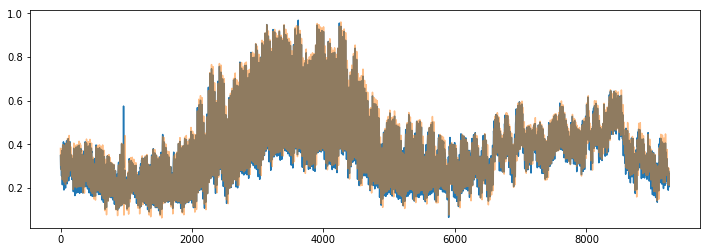

In [38]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(rnn_predictions)), y_test_scaled)
ax.plot(range(len(rnn_predictions)), rnn_predictions, alpha=0.5)

plt.show()